<a href="https://colab.research.google.com/github/androbaza/image-processing-matlab/blob/main/Canny_Edge_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from scipy.ndimage import gaussian_filter
from scipy import signal, misc
from skimage.color import rgb2grey
import matplotlib.image as mpim
import matplotlib.pyplot as plt
import numpy as np

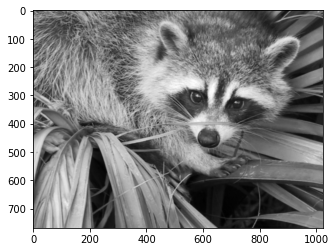

In [3]:
# image = mpim.imread('valve.png')
# image = rgb2grey(fig)
image = misc.face(True)
image = gaussian_filter(image, sigma = 1.1)
plt.imshow(image, cmap="gray")

In [6]:
def scharr(image):
  kernel = np.array([[47, 0, -47], [162, 0, -162], [47, 0, -47]])
  # kernel = np.array([[3, 0, -3], [10, 0, -10], [3, 0, -3]])

  convX, convY = signal.convolve(image, kernel, mode='same'), signal.convolve(image, kernel.T, mode='same')

  G = np.sqrt(np.square(convX) + np.square(convY))
  G *= 255 / G.max()

  Th = np.arctan2(convX, convY)

  return G, np.degrees(Th)

In [9]:
def NMsup (G, Th):
  h, w = G.shape
  suppressed_image = np.zeros(G.shape)

  for y in range(1, h-1):
    for x in range(1, w-1):
      if Th[y,x] > 22.5 and Th[y,x] < 67.5 or Th[y,x] > -157.5 and Th[y,x] < -112.5:
        if G[y,x] < (G[y-1,x-1] or G[y+1,x+1]):
          suppressed_image[y,x] = 0
        else:
          suppressed_image[y,x] = G[y,x]

      elif Th[y,x] >= -22.5 and Th[y,x] <= 22.5 or Th[y,x] >= 157.5 and Th[y,x] <= -157.5:
        if G[y,x] < (G[y-1,x] or G[y+1,x]):
          suppressed_image[y,x] = 0
        else: 
          suppressed_image[y,x] = G[y,x]
      
      elif Th[y,x] >= 67.5 and Th[y,x] <= 112.5 or Th[y,x] >= -112.5 and Th[y,x] <= -67.5:
        if G[y,x] < (G[y,x-1] or G[y,x+1]):
          suppressed_image[y,x] = 0
        else:
          suppressed_image[y,x] = G[y,x]

      elif Th[y,x] > 112.5 and Th[y,x] < 157.5 or Th[y,x] > -67.5 and Th[y,x] < -22.5:
        if G[y,x] < (G[y-1,x+1] or G[y+1,x-1]):
          suppressed_image[y,x] = 0
        else:
          suppressed_image[y,x] = G[y,x]

  return suppressed_image

In [13]:
def cut_low (image, threshold_low, threshold_high):
  h, w = G.shape

  for y in range(0, h):
    for x in range(0, w):
      if image[y,x] >= threshold_high:
        image[y,x] = 255
      elif image[y,x] < threshold_high and image[y,x] > threshold_low:
        image[y,x] = 128
      elif image[y,x] <= threshold_low:
        image[y,x] = 0

  return image

In [ ]:
# def connect_lines (image, threshold):
#   h, w = G.shape

#   for y in range(0, h):
#     for x in range(0, w):


#   return image

In [ ]:
G, Th = scharr(image)
image1 = NMsup(G, Th)
image2 = cut_low(image1, 30, 80)
plt.imshow(image2 , cmap="gray")